In [1]:
import os
import re
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style for nicer aesthetics
sns.set_theme(style="whitegrid")
plt.rcParams.update({'figure.autolayout': True}) 

In [2]:
data_dir = "../../data/replication_gcn/final_model/loss"
file_pattern = r"gcn_(regression|classification)_fold(\d+)_(random|stratified)_seed_\d+_lr_(lr_rep|lr0001|lr001)_dim_dim(\d+)_loss_(train|test)"

In [3]:
all_files = glob.glob(os.path.join(data_dir, '*_fold[0-4]_*.csv'))

file_groups = {}

# Process each file
for file in all_files:
    # Extract the base name by removing the "foldX" part using regex
    base_name = re.sub(r'_fold[0-4]_', '_', os.path.basename(file))
    
    # Group files by the base name
    if base_name in file_groups:
        file_groups[base_name].append(file)
    else:
        file_groups[base_name] = [file]

# Dictionary to store the final averaged DataFrames, with base_name as the key
av_data = {}

# Process each group to add the epoch column, concatenate, and average by epoch
for base_name, files in file_groups.items():
    # List to store DataFrames for each file
    dfs = []

    # Read each file in the group, retain the last 200 rows, add epoch column, and append to dfs list
    for file in files:
        df = pd.read_csv(file)
        
        # Keep only the last 200 rows
        df = df.tail(200)

        # Add 'epoch' column with values from 0 to 199
        df['epoch'] = list(range(200))
        
        # Append to the list
        dfs.append(df)

    # Concatenate all dataframes in the group
    combined_df = pd.concat(dfs, ignore_index=True)
    
    # Group by 'epoch' and calculate the mean
    averaged_df = combined_df.groupby('epoch').mean()

    averaged_df.columns = ['drop', 'loss']
    averaged_df = averaged_df.drop(columns=['drop'])
    
    # Store the averaged DataFrame in the dictionary with the base_name as the key
    av_data[base_name] = averaged_df

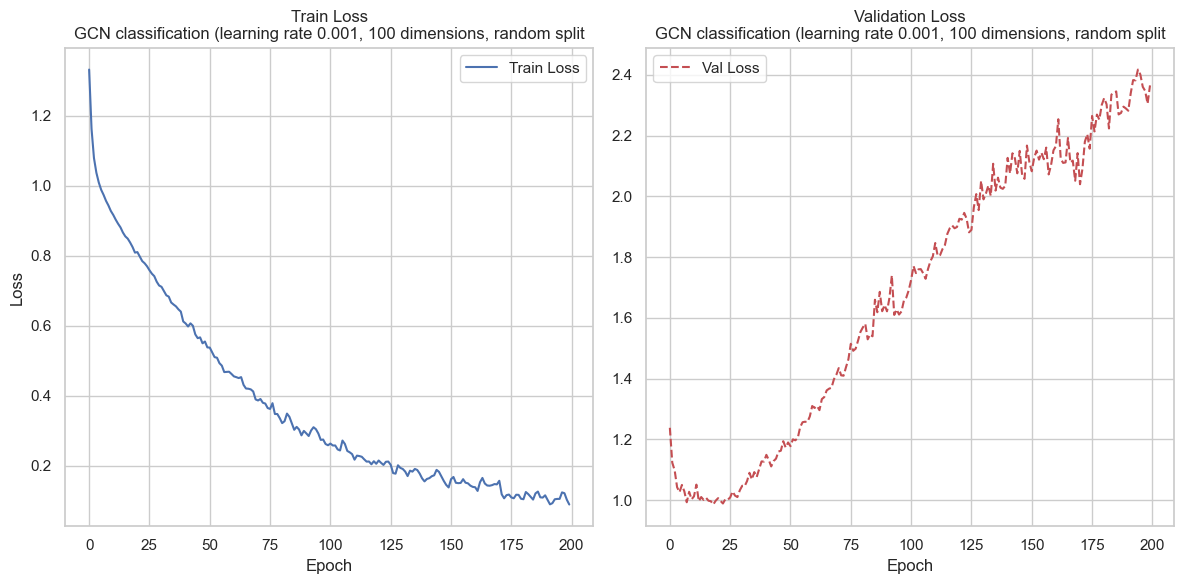

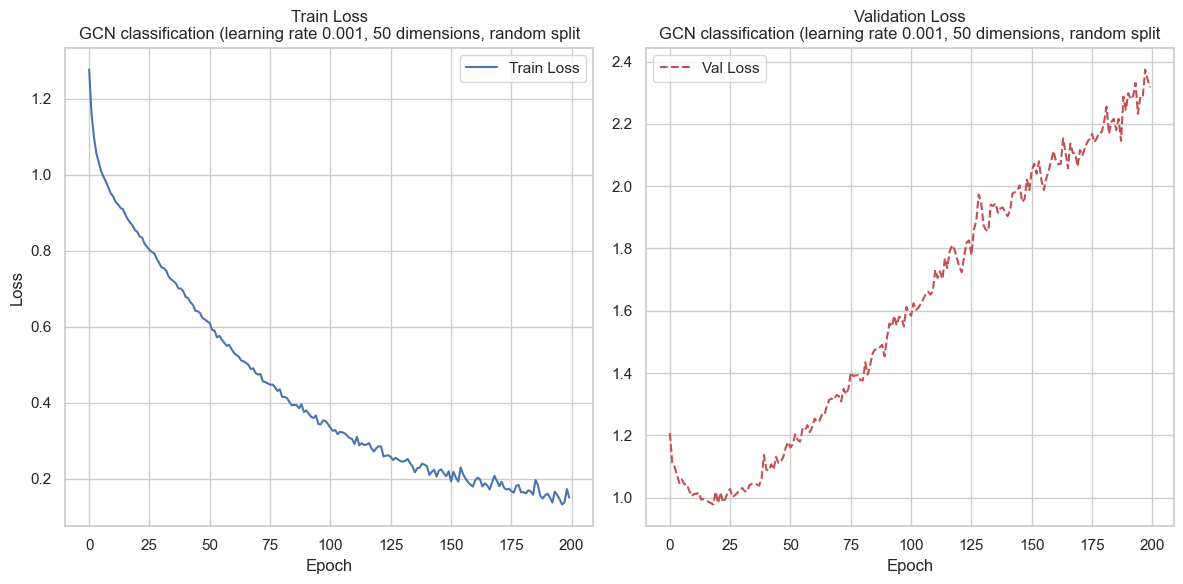

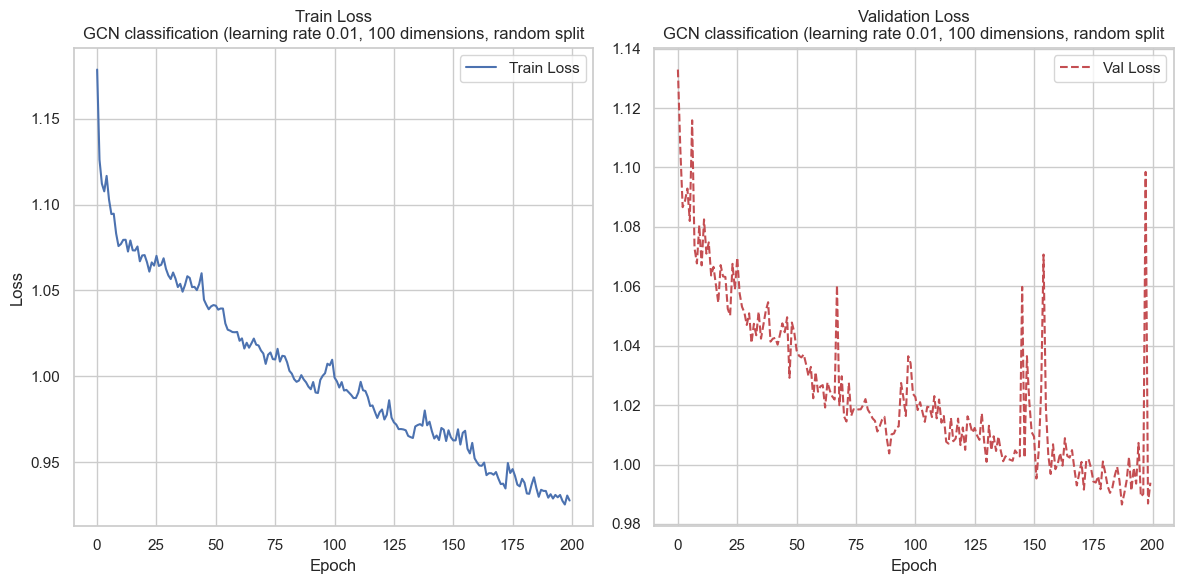

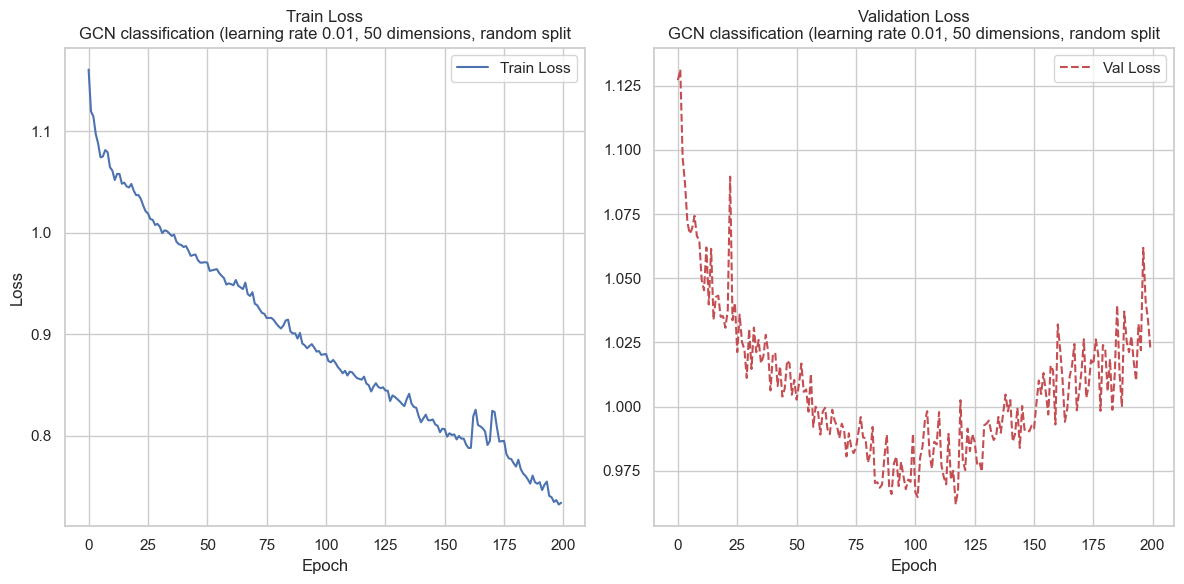

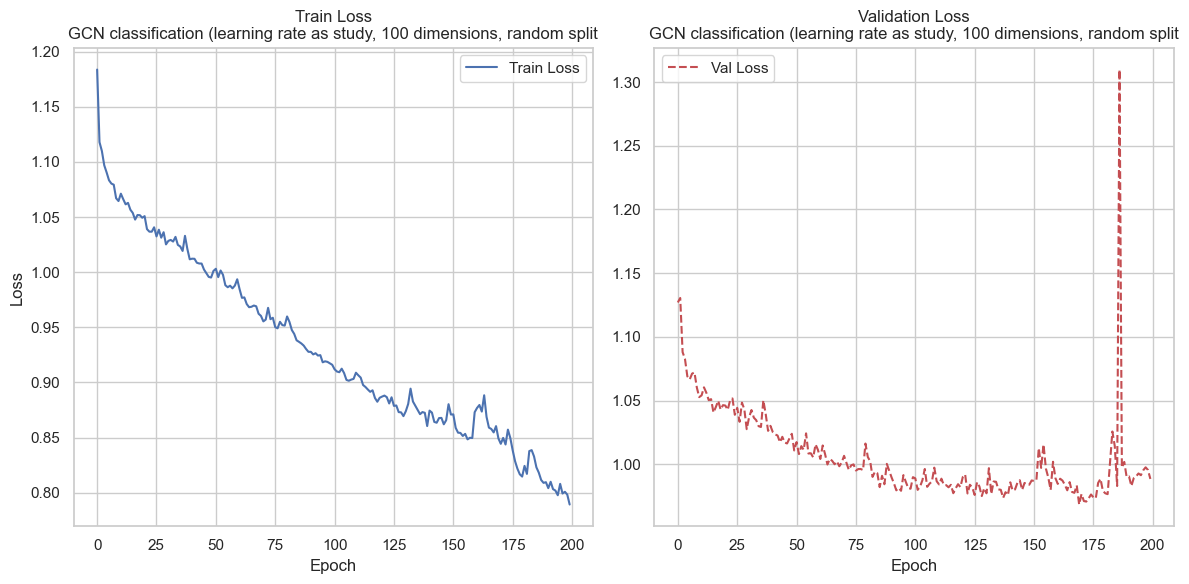

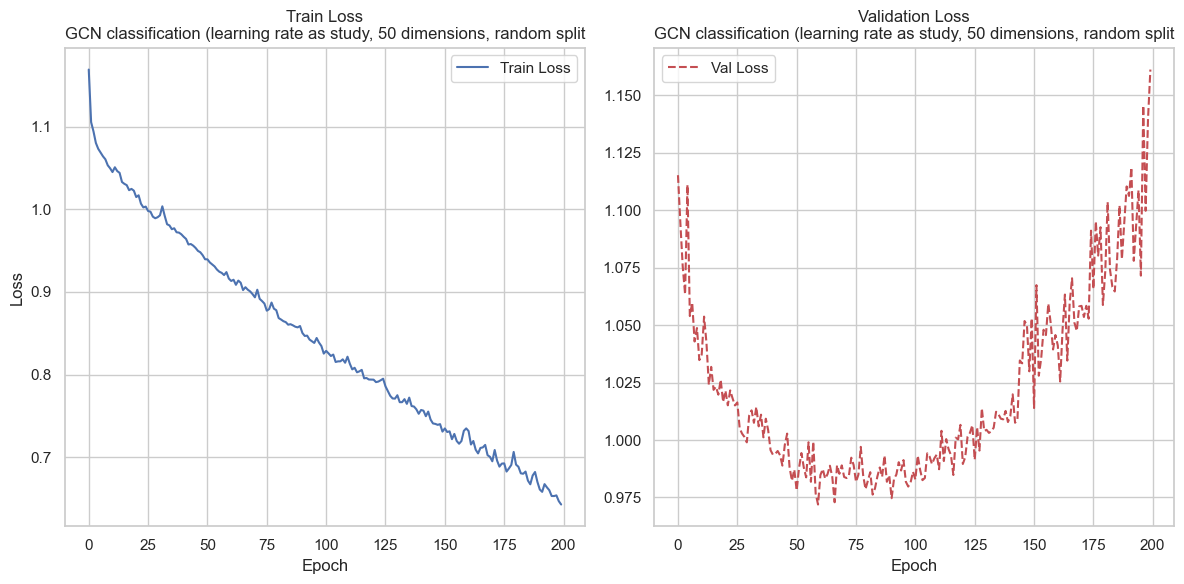

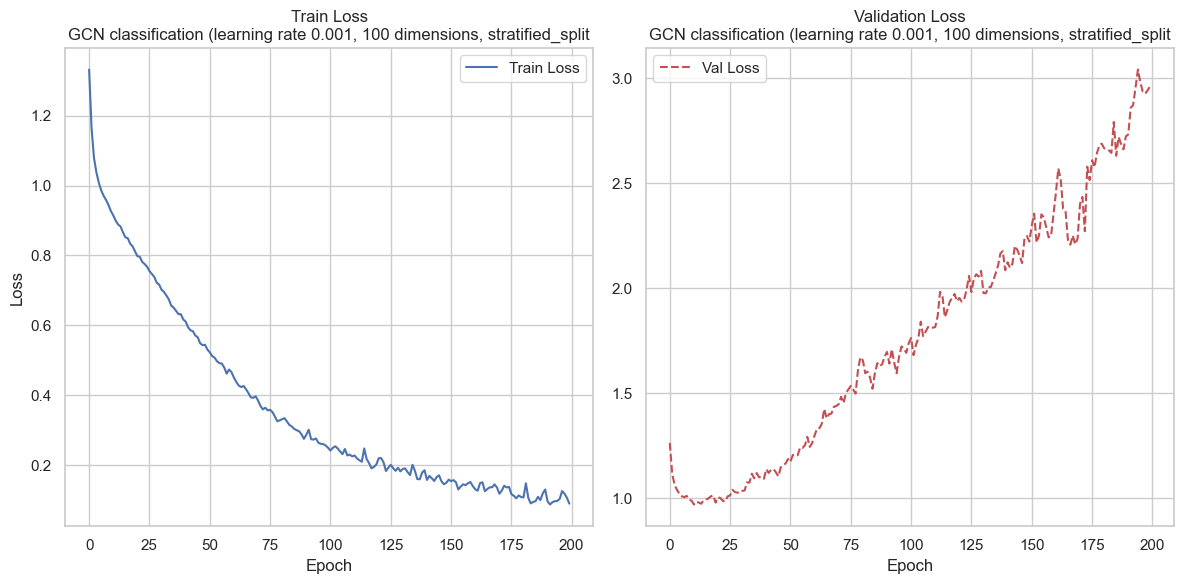

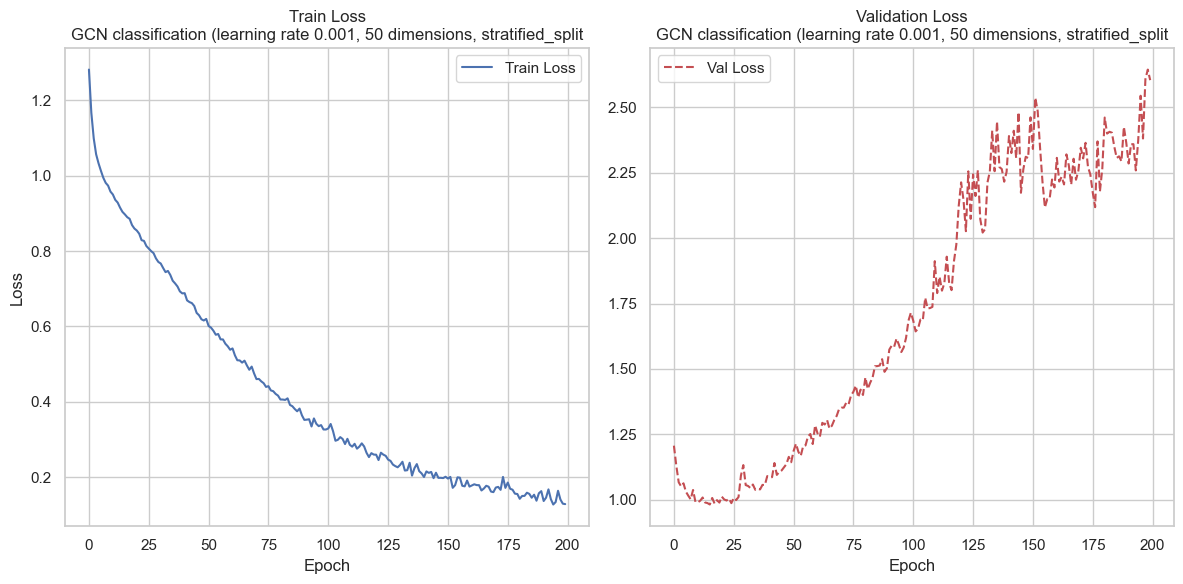

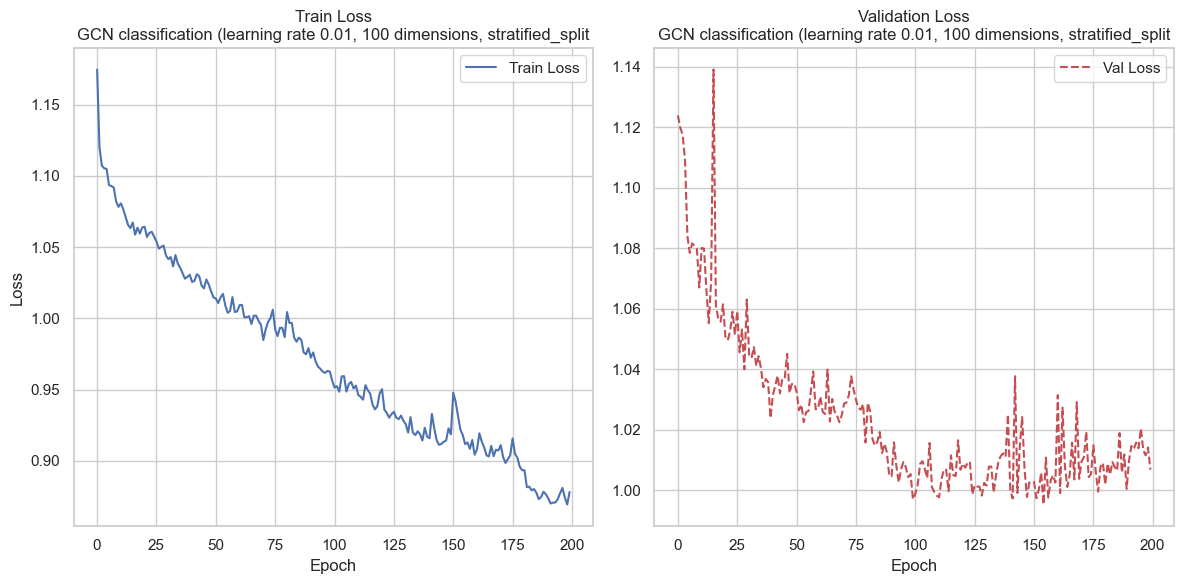

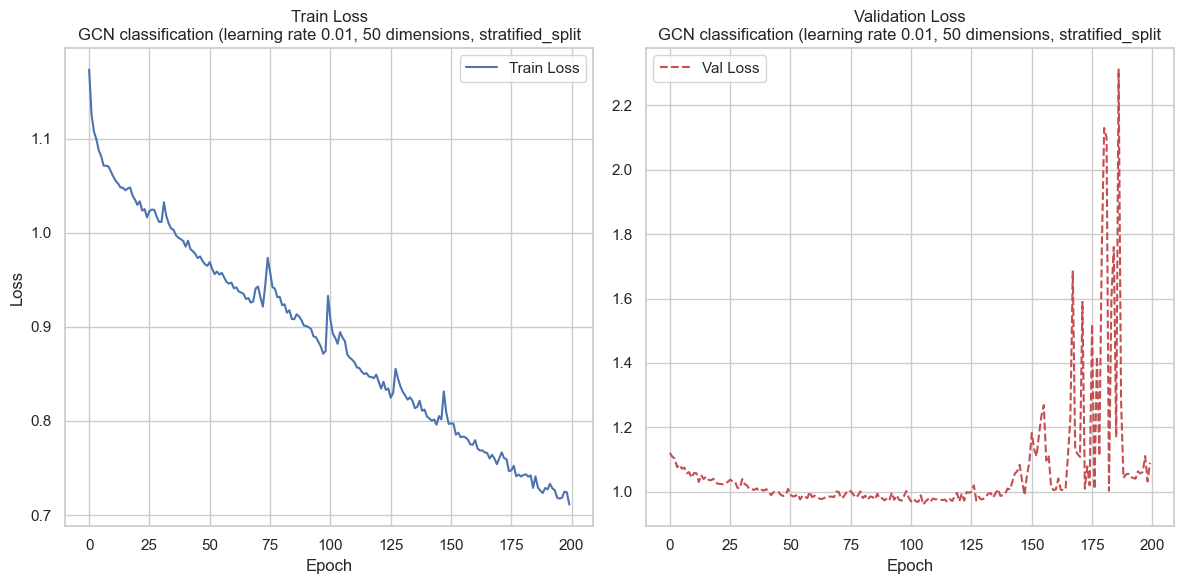

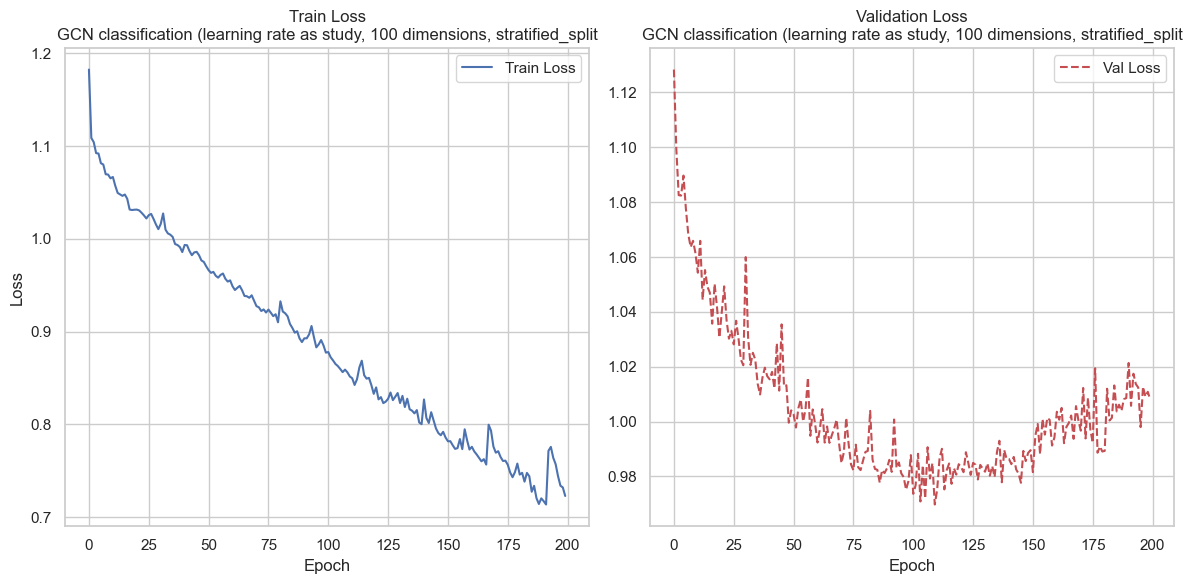

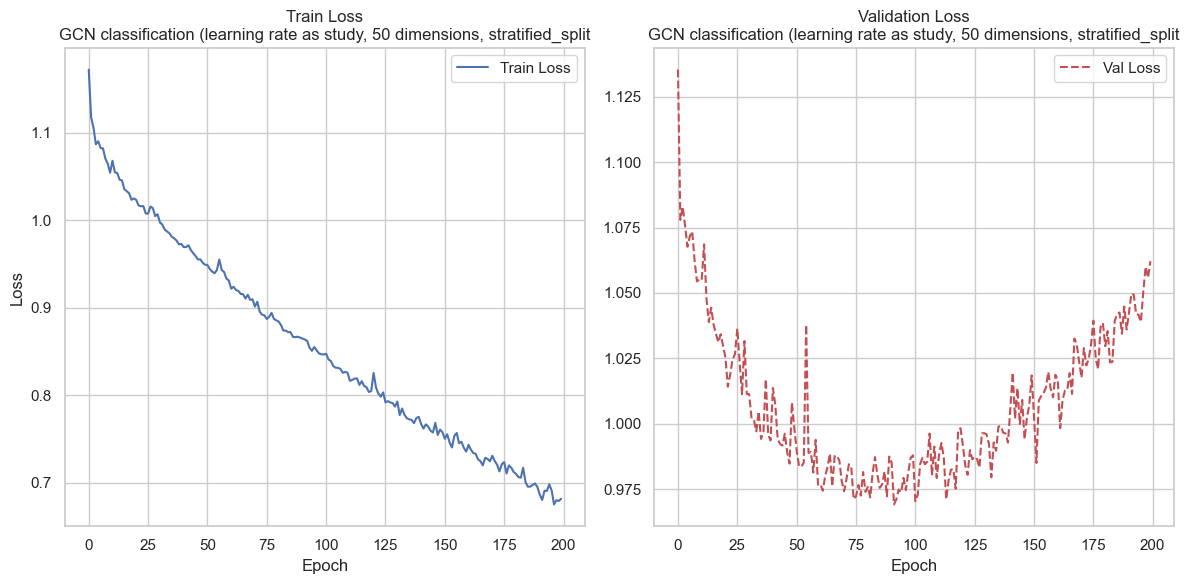

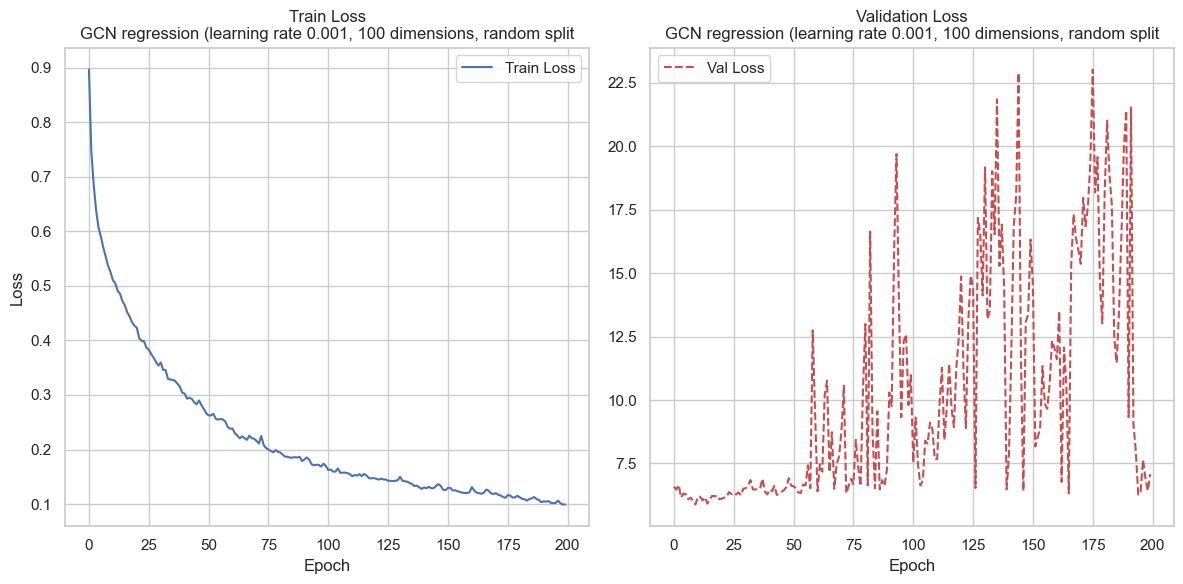

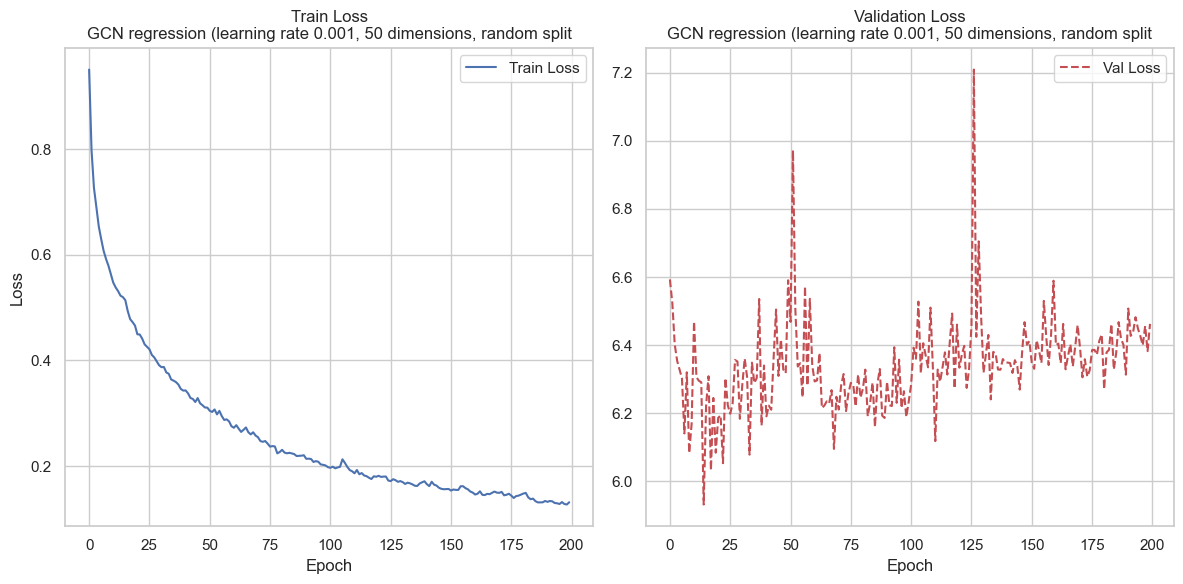

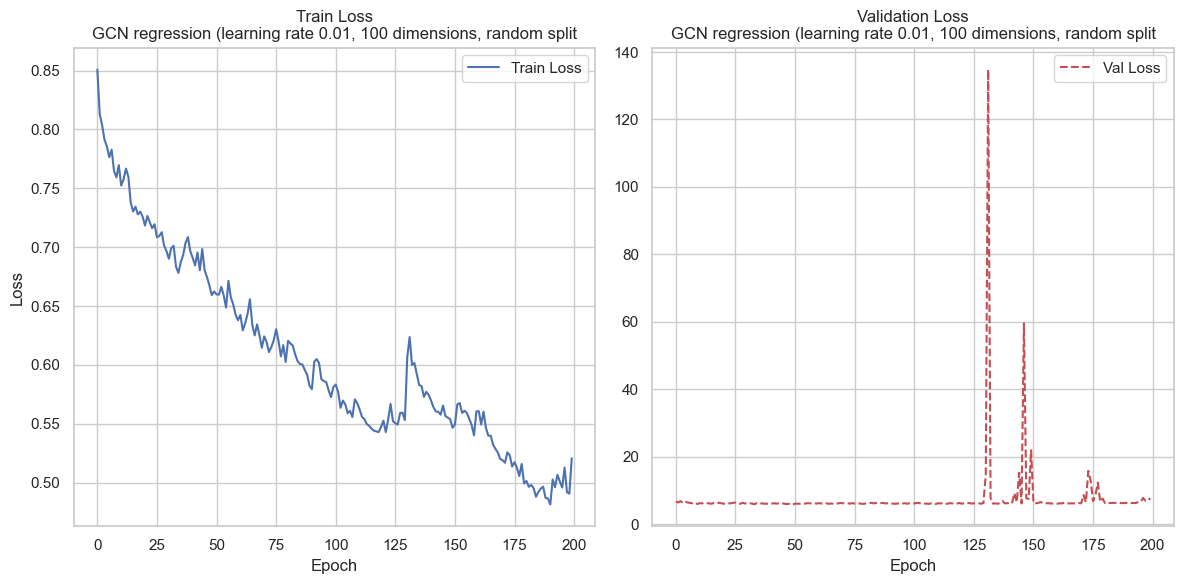

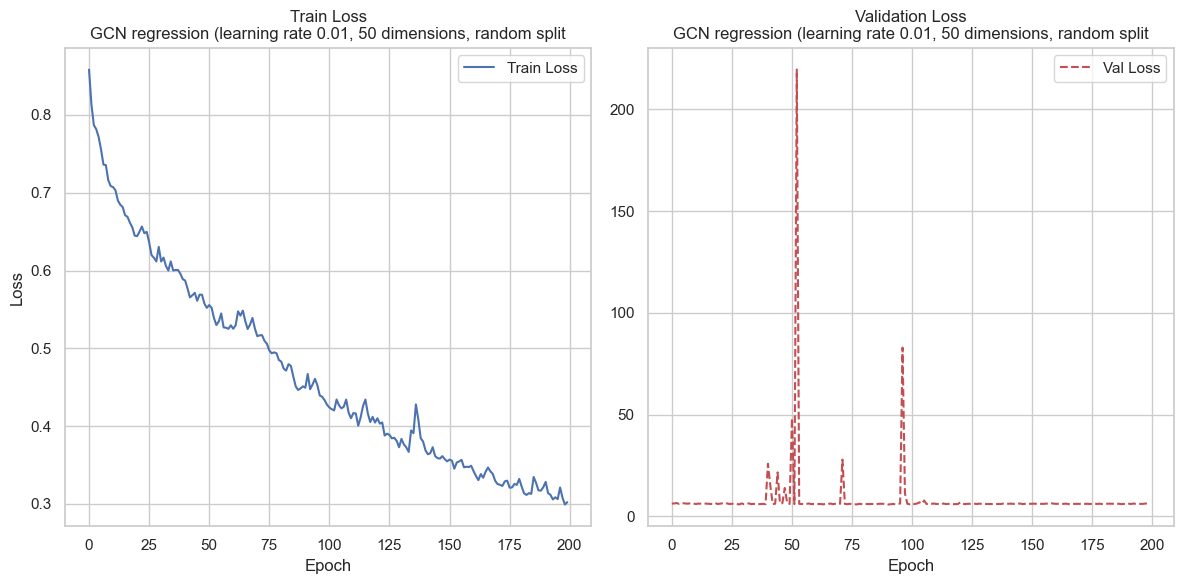

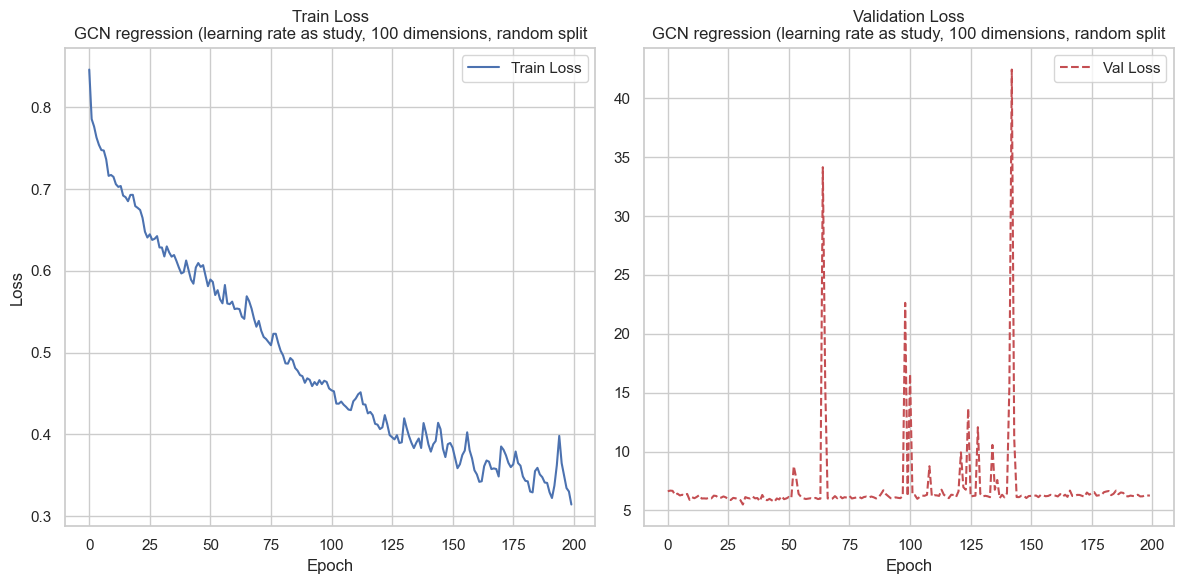

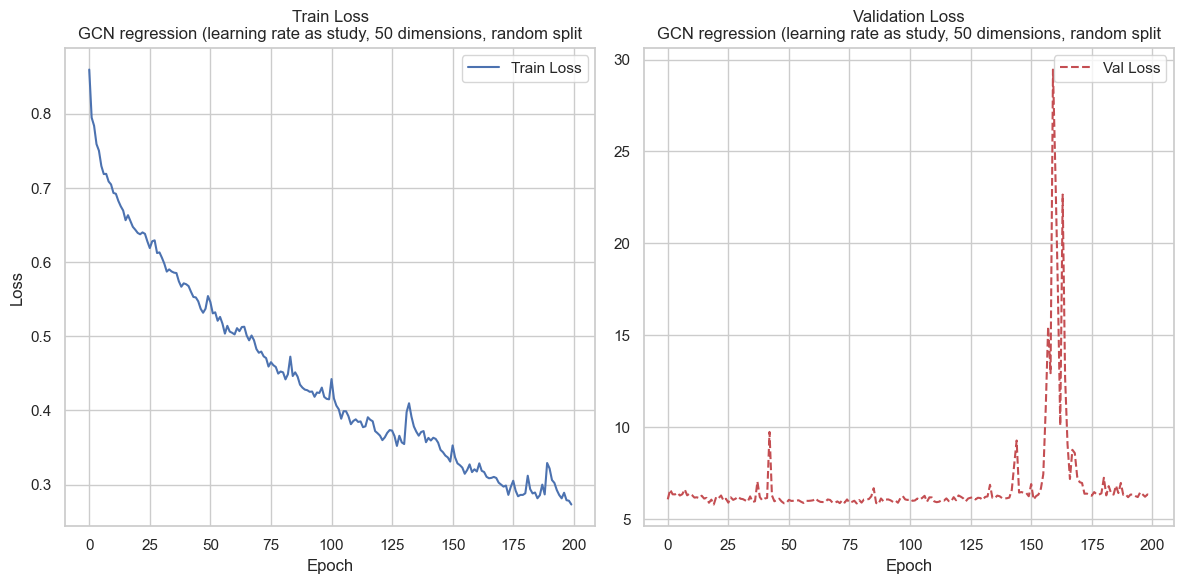

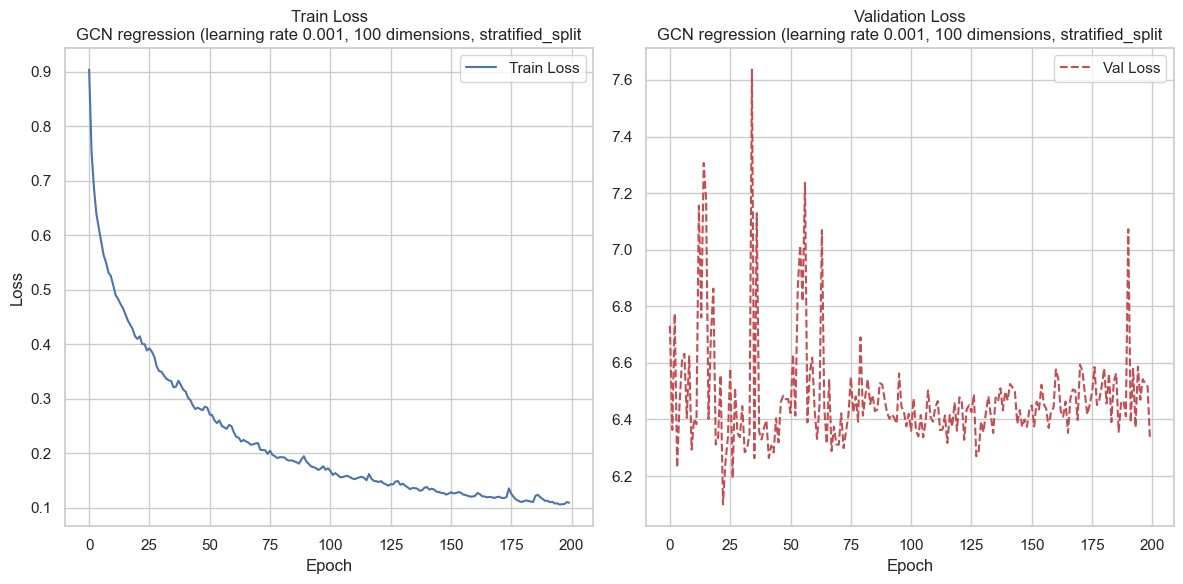

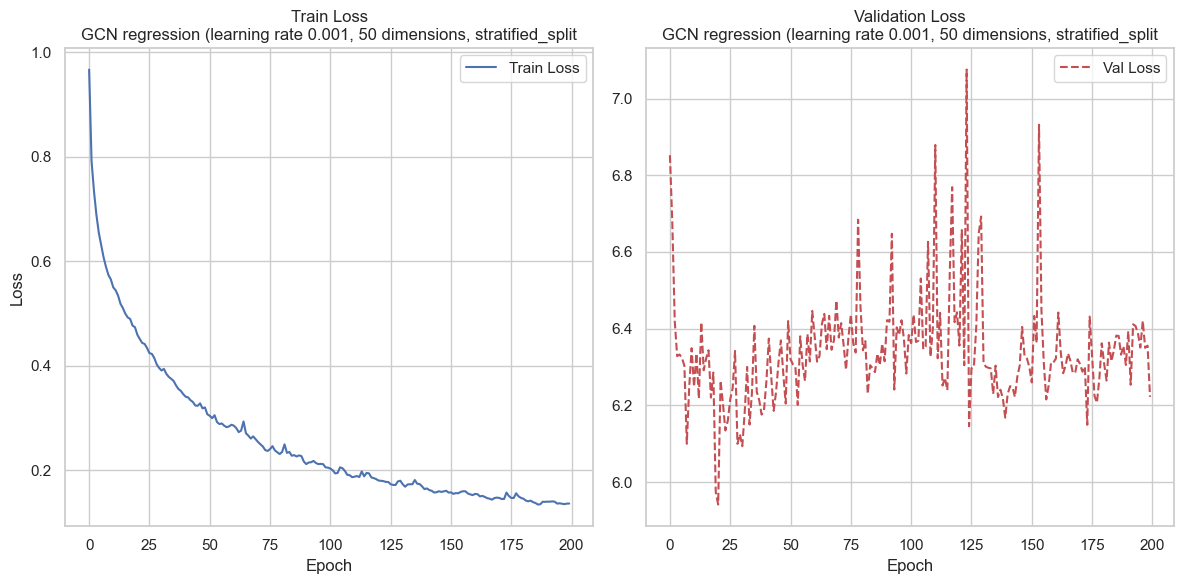

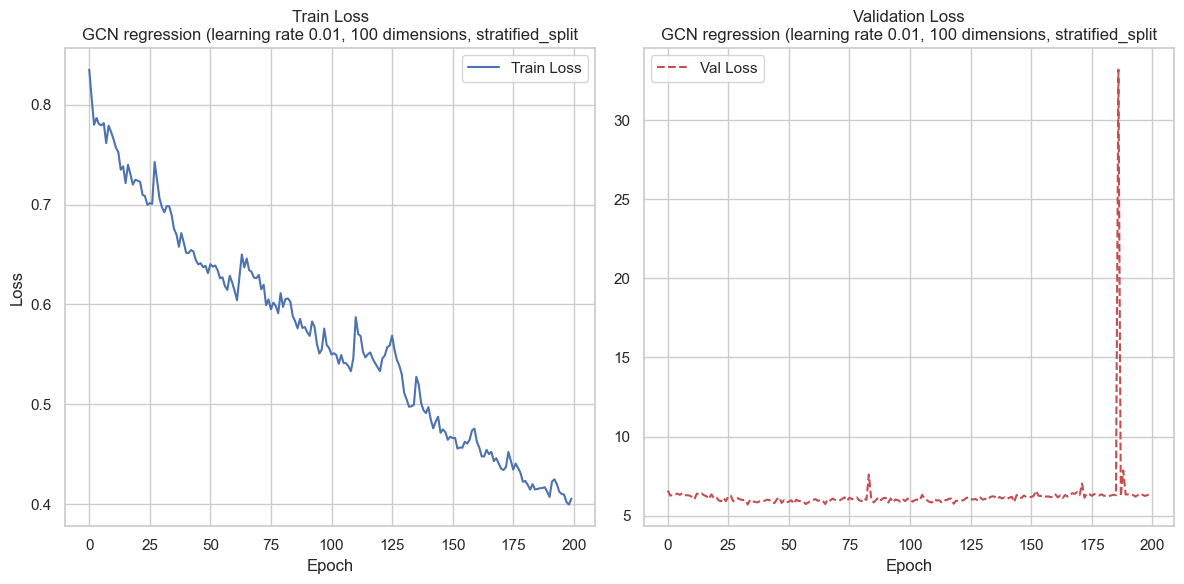

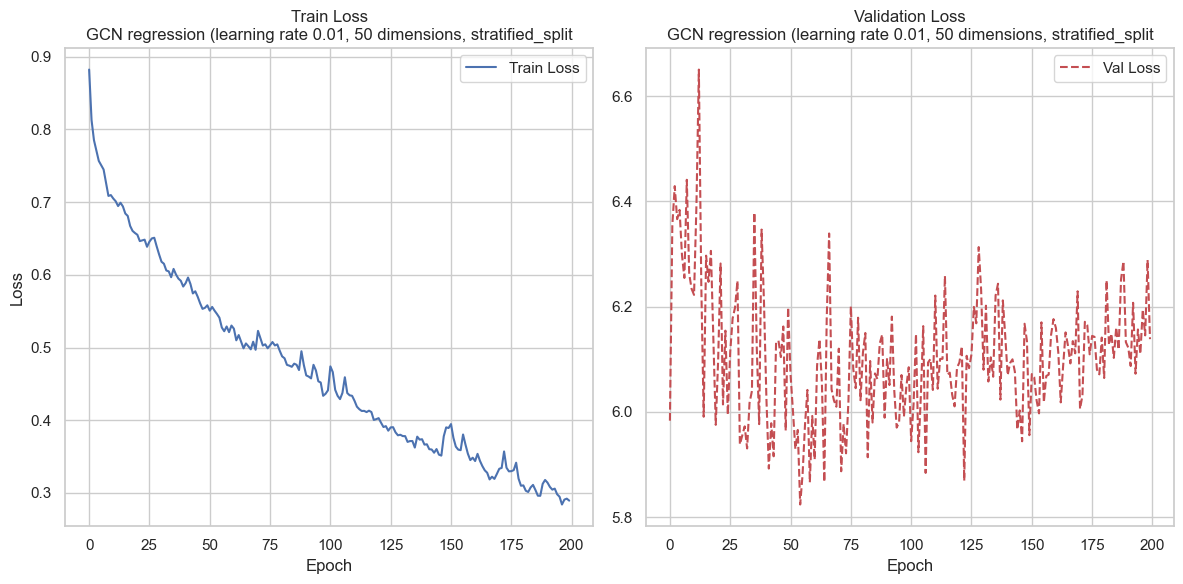

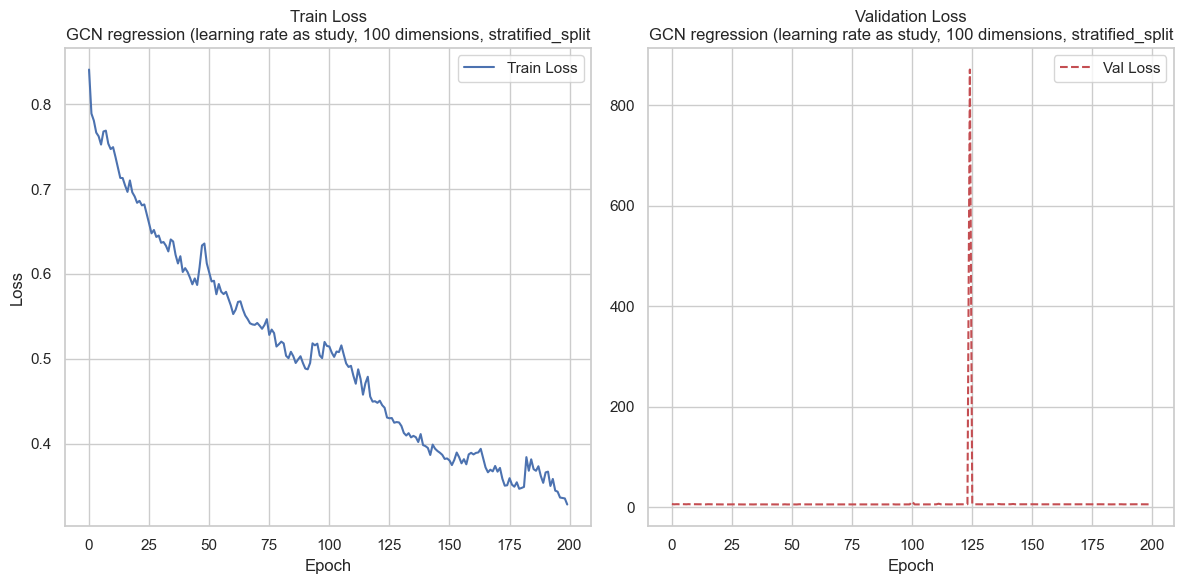

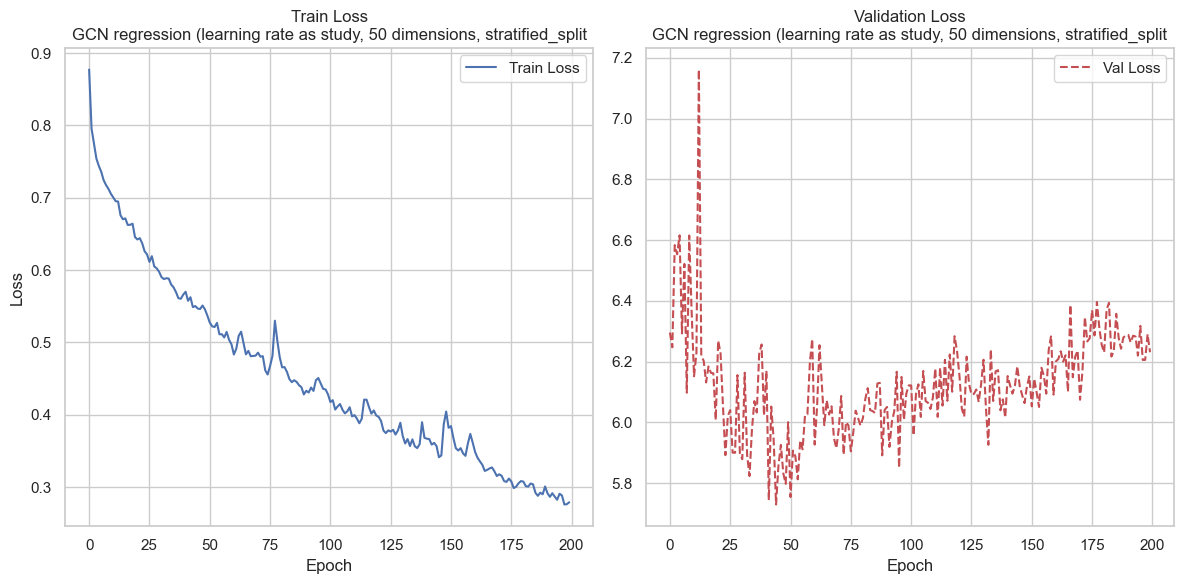

In [16]:
train_val_pairs = []

# Iterate over the dictionary keys
for key in av_data.keys():
    if 'train.csv' in key:
        # Create the corresponding validation and test keys by replacing 'train.csv'
        val_key = key.replace('train.csv', 'val.csv')
        test_key = key.replace('train.csv', 'test.csv')
        
        # Check if either the validation or test key exists
        if val_key in av_data:
            train_val_pairs.append((key, av_data[key], val_key, av_data[val_key]))
        elif test_key in av_data:
            train_val_pairs.append((key, av_data[key], test_key, av_data[test_key]))

# Create a plot for each pair
for i, (train_key, train_data, val_key, val_data) in enumerate(train_val_pairs):
    # Extract the common part of the filename (the part before '_loss_train.csv')
    common_part = train_key.split('_loss_train.csv')[0]

    if 'classification' in common_part:
        title = 'GCN classification '
    else:
        title = 'GCN regression '

    if 'lr0001' in common_part:
        title += '(learning rate 0.001, '
    elif 'lr001' in common_part:
        title += '(learning rate 0.01, '
    else:
        title += '(learning rate as study, '

    if 'dim50' in common_part:
        title += '50 dimensions, '
    elif 'dim100' in common_part:
        title += '100 dimensions, '

    if 'random' in common_part:
        title += 'random split'
    elif 'stratified' in common_part:
        title += 'stratified_split'
    
    # Create a side-by-side plot
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # Left plot: Train Loss
    axs[0].plot(train_data.index, train_data['loss'], label='Train Loss', linestyle='-', color='b')
    axs[0].set_title(f'Train Loss\n{title}')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].grid(True)
    axs[0].legend()

    # Right plot: Validation/Test Loss
    axs[1].plot(val_data.index, val_data['loss'], label='Val Loss', linestyle='--', color='r')
    axs[1].set_title(f'Validation Loss\n{title}')
    axs[1].set_xlabel('Epoch')
    axs[1].grid(True)
    axs[1].legend()

    # Adjust layout and display
    plt.tight_layout()
    plt.show()
